In [67]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random

from os import path
from keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from keras import layers, losses, optimizers, metrics, callbacks

In [68]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [69]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 32

In [85]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [71]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)
train_labels_df

,name,codes
0,1.png,6
1,100.png,1
2,10001.png,1
3,10002.png,6
4,10003.png,6
...,...,...
34995,9994.png,1
34996,9996.png,3
34997,9997.png,9
34998,9998.png,1


In [72]:
dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y : (x, tf.one_hot(y, N_CLASS)))

Found 35000 files belonging to 1 classes.


In [73]:
val_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'val.csv')).drop(["Unnamed: 0"], axis=1)
val_labels_df

,name,codes
0,10.png,3
1,1000.png,5
2,10000.png,5
3,10014.png,6
4,10029.png,7
...,...,...
4995,9961.png,8
4996,9977.png,3
4997,998.png,1
4998,9986.png,0


In [74]:
dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'val'),
    labels=list(val_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_val = dataset_val.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 5000 files belonging to 1 classes.


In [80]:
test_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'test.csv')).drop(["Unnamed: 0"], axis=1)

dataset_test = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'test'),
    labels=list(test_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_test = dataset_test.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 10000 files belonging to 1 classes.


In [75]:
X, y = next(iter(dataset_train))
X.shape, y.shape

(TensorShape([512, 32, 32, 3]), TensorShape([512, 10]))

AttributeError: Can only use .cat accessor with a 'category' dtype

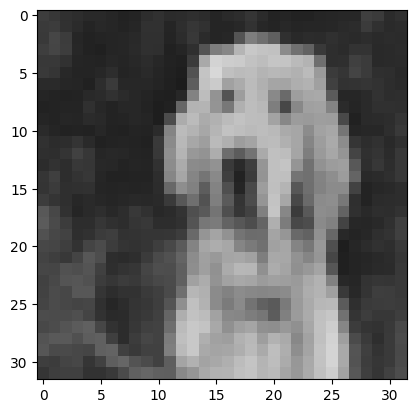

In [76]:
plt.imshow(X[3].numpy().astype(int))
plt.xlabel(train_labels_df.codes.cat.categories[np.argwhere(y[3].numpy()).flatten()])

In [19]:
y[3]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)>

## Simple keras sequential model

In [84]:
def create_model():
    model = keras.Sequential()

    model.add(keras.Input(shape=(32, 32, 3)))

    model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D(2))

    # Fully connected classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(N_CLASS, activation="softmax"))
    return model

model = create_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

In [81]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
)
checkpoint = callbacks.ModelCheckpoint(
    filepath="simple_cnn.h5",
    monitor="val_categorical_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

In [78]:
history = model.fit(
    dataset_train,
    epochs=25,
    workers=2,
    use_multiprocessing=True,
    validation_data=dataset_val,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/25
 8/69 [==>...........................] - ETA: 57s - loss: 24.6690 - categorical_accuracy: 0.1104 - categorical_crossentropy: 24.6690

KeyboardInterrupt: 

## Experiments

Training will be repeated 10 times with different weights initialization.

In [82]:
TRAINING_SEEDS = list(range(10))
results = []
for seed in TRAINING_SEEDS:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_model()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
    )

    history = model.fit(
        dataset_train,
        epochs=25,
        workers=2,
        use_multiprocessing=True,
        validation_data=dataset_val,
        shuffle=True,
        callbacks=[early_stopping, reduce_lr]
    )
    eval_results = model.evaluate(dataset_test)

    results += [{
        'seed': seed,
        'results': dict(zip(model.metrics_names, eval_results))
    }]

results = pd.DataFrame(results)
results = pd.concat([results.drop(["results"], axis=1), results["results"].apply(pd.Series)], axis=1)
results.to_csv('simple_cnn_results.csv')

Epoch 1/25
25/69 [=========>....................] - ETA: 40s - loss: 5.1160 - categorical_accuracy: 0.1161 - categorical_crossentropy: 5.1160

KeyboardInterrupt: 